Epoch [1/200], Loss: 0.3648
Epoch [20/200], Loss: 0.2631
Epoch [40/200], Loss: 0.2581
Epoch [60/200], Loss: 0.2411
Epoch [80/200], Loss: 0.2411
Epoch [100/200], Loss: 0.2426
Epoch [120/200], Loss: 0.2325
Epoch [140/200], Loss: 0.2332
Epoch [160/200], Loss: 0.2290
Epoch [180/200], Loss: 0.2254
Epoch [200/200], Loss: 0.2310

Test MSE Loss: 0.2065
Test RMSE: 0.5243


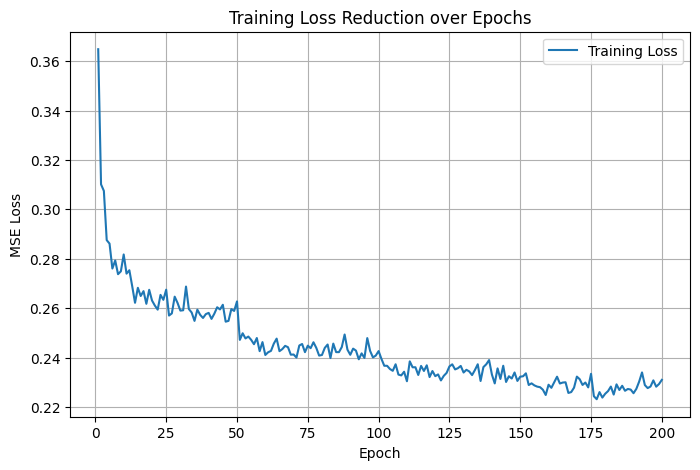

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load the Dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target.reshape(-1, 1)

# 2. Preprocess the Data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 3. Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Build the Regression Model
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# Initialize Model
input_dim = X_train.shape[1]
model = HousePriceModel(input_dim)

# 5. Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# 6. Train the Model
num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * features.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    if (epoch+1) % 20 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save the model
torch.save(model.state_dict(), 'house_price_model.pth')

# 7. Evaluate the Model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor).item()
    print(f"\nTest MSE Loss: {test_loss:.4f}")

# Inverse Transform for Comparison
predictions_unscaled = scaler_y.inverse_transform(predictions.detach().numpy())
y_test_unscaled = scaler_y.inverse_transform(y_test_tensor.numpy())

rmse = np.sqrt(np.mean((predictions_unscaled - y_test_unscaled)**2))
print(f"Test RMSE: {rmse:.4f}")

# 8. Visualize Training Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Reduction over Epochs')
plt.legend()
plt.grid(True)
plt.show()
